In [1]:
# Project Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths
data_dir = '../data/jp_morgan'

In [2]:
# Load data
aml_data = pd.read_csv(f'{data_dir}/aml_syn_data.csv')
fraud_data = pd.read_csv(f'{data_dir}/fraud_payment_data.csv')



In [3]:
common_columns = [
    'Time_step',
    'Label',
    'Transaction_Id',
    'Transaction_Type',
    'Sender_Id',
    'Sender_Account',
    'Sender_Country',
    'Bene_Id', 
    'Bene_Account',
    'Bene_Country',
    'USD_amount',
]
aml_data = aml_data[common_columns]
fraud_data = fraud_data[common_columns]

Feature Columns:
* hour of transaction
* normalised age on transaction

In [4]:
# AML Data Preprocessing
# Filter only money movements
aml_data = aml_data[aml_data['Transaction_Type'].isin(['WIRE', 'PAYMENT', 'WITHDRAWL', 'CASH-DEPOSIT', 'CRYPTO-TRANSFER'])].reset_index()

# Identify if row is reversed for party v counterparty retabling
def party_reverse_flag(df, sender_col='Sender_Id', bene_col='Bene_Id', transaction_col='Transaction_Type'):
    df.loc[:, 'sender_type'] = df[sender_col].str.split('-').str[:2].str.join('-')
    df.loc[:, 'benef_type'] = df[bene_col].str.split('-').str[:2].str.join('-')
    condition = (
        (df[transaction_col] == 'CASH-DEPOSIT') |
        ((df[transaction_col] == 'WIRE') & (df['benef_type'] == 'JPMC-CLIENT'))
    )
    df.loc[:, 'reversed'] = condition
    return df

aml_data = party_reverse_flag(aml_data)

In [5]:
# Create party v counterparty retabling
def new_table(df, rev_col='reversed', retained_cols=[]):
    for type in ('Id', 'Account', 'Country'):
        df.loc[:, f'party_{type}'] = df[f'Sender_{type}'].where(~df[rev_col], df[f'Bene_{type}'])
        df.loc[:, f'cparty_{type}'] = df[f'Bene_{type}'].where(~df[rev_col], df[f'Sender_{type}'])
    retained_cols.extend(['party_Id', 'party_Account', 'party_Country',
                          'cparty_Id', 'cparty_Account', 'cparty_Country'])
    new_table = df[retained_cols]
    return new_table

aml_data = new_table(aml_data, retained_cols=['Time_step', 'Label',
    'Transaction_Id',
    'Transaction_Type',
    'USD_amount'])

In [6]:
# Normalise date and extract hour minutes
def feature_time(df, dt_column='Time_step'):
    time_series = pd.to_datetime(df[dt_column])
    df['time_hr'] = time_series.dt.hour
    df['time_mm'] = time_series.dt.minute
    
    return df

def normalise_date(df, dt_column='Time_step', primary_col='party_Id'):
    time_series = pd.to_datetime(df[dt_column])
    df['txn_age'] = (time_series - time_series.groupby(df[primary_col]).transform('min')).dt.days
    
    return df

aml_data = feature_time(aml_data)
aml_data = normalise_date(aml_data)


In [21]:
# Extract previous transaction details
def fill_prev_txn(df, primary_key='party_Id', dt_column='Time_step', columns_to_fill=[], shift=1, include_age_delta=False):
    core_columns = [primary_key, dt_column]
    temp_df = df[core_columns + columns_to_fill].copy()

    temp_df[dt_column] = pd.to_datetime(temp_df[dt_column])
    temp_df = temp_df.sort_values([primary_key, dt_column])
    
    new_columns = ['prev_' + col for col in columns_to_fill]

    temp_df[new_columns] = temp_df.groupby(primary_key)[columns_to_fill].shift(shift)
    if include_age_delta:
        temp_df['prev_age_delta'] = ((temp_df[dt_column] - temp_df.groupby(primary_key)[dt_column].shift(shift)).dt.total_seconds())/(24 * 3600)
        new_columns.append('prev_age_delta')
    
    return df.merge(temp_df[new_columns], left_index=True, right_index=True)

aml_data = fill_prev_txn(aml_data, columns_to_fill=['Transaction_Type', 'USD_amount'])

In [22]:
aml_data = fill_prev_txn(aml_data, include_age_delta=True)

In [ ]:
# Transaction Volume Deviation

In [ ]:
# Scratch

# Loaded variable 'aml_data' from kernel state

aml_data['Time_step'] = pd.to_datetime(aml_data['Time_step'])

aml_data['txn_dt_min'] = aml_data.groupby('party_Id')['Time_step'].transform('min')
aml_data.loc[:, 'txn_age'] = (aml_data['Time_step'].dt.date - aml_data['txn_dt_min'].dt.date)

In [10]:
test_b = aml_data[:10].copy()
test_b.columns = ['b_' + x for x in test_b.columns]
test_a = aml_data[:10].copy()

In [9]:
df = aml_data.copy()

In [19]:
df = feature_time(df, 'Time_step')

In [11]:
df['Time_step']
timestamp = pd.to_datetime(df['Time_step'])

In [6]:
aml_senders = aml_data[['Sender_Id', 'Sender_Account']].drop_duplicates().
fraud_senders = fraud_data[['Sender_Id', 'Sender_Account']].drop_duplicates()

SyntaxError: invalid syntax (1547740258.py, line 1)

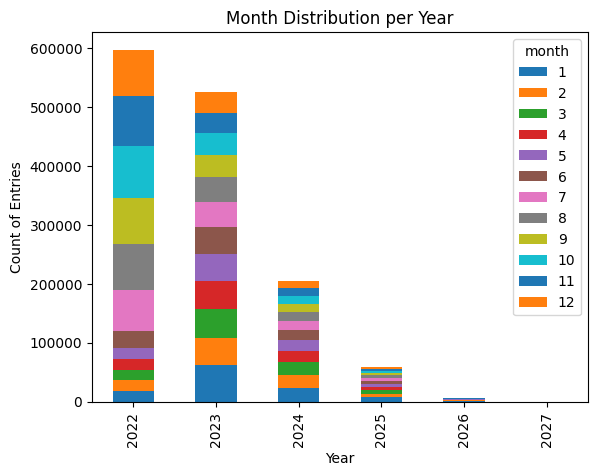

In [12]:
def plot_hist_df(df):
    df['date'] = pd.to_datetime(df['Time_step'])
    # Extract the year and month
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

    # Plot the distribution of months per year
    df.groupby(['year', 'month']).size().unstack().plot(kind='bar', stacked=True)

    plt.xlabel('Year')
    plt.ylabel('Count of Entries')
    plt.title('Month Distribution per Year')
    plt.show()

plot_hist_df(aml_data)

In [22]:
aml_data['Label'].map({'GOOD': 0, 'BAD': 1})

0          0
1          0
2          0
3          0
4          0
          ..
1484531    0
1484532    0
1484533    0
1484534    0
1484535    0
Name: Label, Length: 1484536, dtype: int64